## Importing packages

In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
#import pydicom

import os
import glob
import h5py
import shutil

#import imgaug as aug

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
#import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser

from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import img_to_array

import itertools

color = sns.color_palette()



Using TensorFlow backend.


In [3]:
## Reading data

In [4]:
# Define path to the data directory
data_dir = os.path.join('..', 'D:\Skin cancer\Spring\Data aug')


In [5]:
# Set folder names as labels
akiec_cases = data_dir + '//' + 'akiec//*'
bcc_cases = data_dir + '//' + 'bcc//*'
bkl_cases = data_dir + '//' + 'bkl//*'
df_cases = data_dir + '//' + 'df//*'
mel_cases = data_dir + '//' + 'mel//*'
nv_cases = data_dir + '//' + 'nv//*'
vasc_cases = data_dir + '//' + 'vasc//*'


# Get the list of all the images
akiec_cases = glob.glob(akiec_cases)
bcc_cases = glob.glob(bcc_cases)
bkl_cases = glob.glob(bkl_cases)
df_cases = glob.glob(df_cases)
mel_cases = glob.glob(mel_cases)
nv_cases = glob.glob(nv_cases)
vasc_cases = glob.glob(vasc_cases)

# Set counter
import random

akiec_cases = random.sample(akiec_cases, 2000)

bcc_cases = random.sample(bcc_cases, 2000)

bkl_cases = random.sample(bkl_cases, 2000)

df_cases = random.sample(df_cases, 2000)

mel_cases = random.sample(mel_cases, 2000)

nv_cases = random.sample(nv_cases, 2000)

vasc_cases = random.sample(vasc_cases, 2000)



## Preparing train, test and val data

# Train data

In [6]:
# List that are going to contain validation images data and the corresponding labels
train_data = []
train_label = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224

# All Cases
cases = [akiec_cases, bcc_cases, bkl_cases, df_cases, mel_cases, nv_cases, vasc_cases]
for case_num in range(7):
    for img in cases[case_num]:
        img = cv2.imread(str(img))
        img = cv2.resize(img, (224,224))
        img = img.astype(np.float32)/255.
        label = to_categorical(case_num, num_classes=7)
        train_data.append(img)
        train_label.append(label)

# Convert the list into numpy arrays
train_data = np.array(train_data)
train_label = np.array(train_label)

print("Total number of examples: ", train_data.shape)
print("Total number of labels:", train_label.shape)



Total number of examples:  (14000, 224, 224, 3)
Total number of labels: (14000, 7)


In [7]:
# Split dataset into train, test and validate
from sklearn.model_selection import train_test_split
data_train, data_test, label_train, label_test = train_test_split(train_data, train_label, test_size=0.20,shuffle=True)
number_of_train = data_train.shape[0]
number_of_test = data_test.shape[0]
# print('Train', number_of_train)
print('Test',number_of_test)

from sklearn.model_selection import train_test_split
data1_train, data_val, label1_train, label_val = train_test_split(data_train, label_train, test_size=0.20, shuffle=True)
number_of_train = data1_train.shape[0]
number_of_validate = data_val.shape[0]
print('Train', number_of_train)
print('Validate',number_of_test)

Test 2800
Train 8960
Validate 2800


## Defining a basic CNN Model

In [8]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils, to_categorical
from keras.utils.data_utils import get_file
from keras.callbacks import Callback
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

%matplotlib inline 
#plotting directly without requering the plot()

import warnings
warnings.filterwarnings(action="ignore") #ignoring most of warnings, cleaning up the notebook for better visualization

pd.set_option('display.max_columns', 500) #fixing the number of rows and columns to be displayed
pd.set_option('display.max_rows', 500)


In [9]:
#identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [10]:
#convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b', padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [11]:
def ResNet50(input_shape=(224, 224, 3), classes=7):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = Activation('relu')(X)
   

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((7,7), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [12]:
model = ResNet50(input_shape = (224, 224, 3), classes = 7)

In [13]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

### Defining Callbacks

In [14]:
#Reduce learning rate on plateau
# es = EarlyStopping(monitor='val_loss',verbose=1, restore_best_weights=True, patience=2)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3,
                                            mode='auto',
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.01)

### Fit/Train Model

In [15]:
num_epochs = 30
batch_size = 32
history = model.fit(data_train,label_train,
                    batch_size=batch_size,
                    shuffle = True,
                    epochs=num_epochs,
                    validation_data = (data_val, label_val),
                    verbose=1,
                    callbacks = [learning_rate_reduction])

Train on 11200 samples, validate on 2240 samples
Epoch 1/30
11200/11200 [==============================] - 204s 18ms/step - loss: 1.3045 - accuracy: 0.5258 - val_loss: 0.9347 - val_accuracy: 0.6353
Epoch 2/30
11200/11200 [==============================] - 198s 18ms/step - loss: 0.8944 - accuracy: 0.6518 - val_loss: 0.7477 - val_accuracy: 0.7196
Epoch 3/30
11200/11200 [==============================] - 198s 18ms/step - loss: 0.7602 - accuracy: 0.7076 - val_loss: 0.6782 - val_accuracy: 0.7469
Epoch 4/30
11200/11200 [==============================] - 199s 18ms/step - loss: 0.6723 - accuracy: 0.7402 - val_loss: 0.5494 - val_accuracy: 0.7920
Epoch 5/30
11200/11200 [==============================] - 199s 18ms/step - loss: 0.5889 - accuracy: 0.7745 - val_loss: 0.5436 - val_accuracy: 0.7884
Epoch 6/30
11200/11200 [==============================] - 199s 18ms/step - loss: 0.5258 - accuracy: 0.7998 - val_loss: 0.4273 - val_accuracy: 0.8357
Epoch 7/30
11200/11200 [==============================] -

### Loss/Acc Graph

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


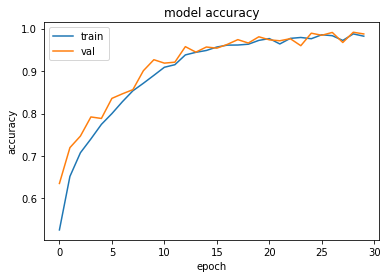

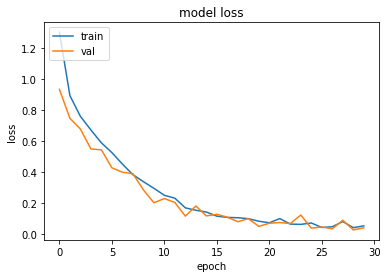

In [16]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Confusion Matrix

Overall Accuracy:  0.8492857142857143
              precision    recall  f1-score   support

       akiec       0.87      0.79      0.83       408
         bcc       0.92      0.80      0.86       432
         bkl       0.75      0.81      0.78       398
          df       0.88      0.91      0.89       405
         mel       0.77      0.80      0.78       372
          nv       0.90      0.88      0.89       398
        vasc       0.87      0.95      0.91       387

    accuracy                           0.85      2800
   macro avg       0.85      0.85      0.85      2800
weighted avg       0.85      0.85      0.85      2800



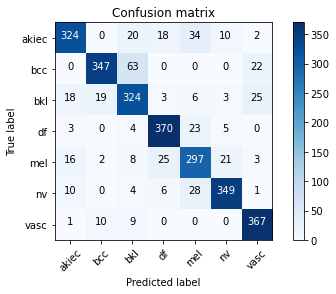

In [26]:
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

classes=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
# Predict the values from the validation dataset
Y_pred = model.predict(data_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(label_test, axis = 1) 
# compute the confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(cm, classes)
# Find accuracy
from sklearn import metrics
print("Overall Accuracy: ", metrics.accuracy_score(Y_true, Y_pred_classes))
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes, target_names=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']))
